# Baseline Code for HW2

This is just the baseline code to set up the basic function you need. You need to modify the code yourself to achieve a better result.

About the Dataset
The dataset used here is flower-9, a collection of food images in 9 classes.

The data have been slightly modified by the TA. Please DO NOT access the original fully-labeled training data or testing labels.

## Import packages you need

In [1]:
# Import necessary packages.
import os
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset
from torchvision.datasets import DatasetFolder

#If you haven't download the tqdm package, just uncomment the following line.
#!pip install tqdm
# This is for the progress bar.
from tqdm.auto import tqdm


In [16]:
import warnings
warnings.filterwarnings('ignore')


In [2]:
def custom_collate_fn(batch):
    imgs, labels = zip(*batch)  # 解包批数据
    imgs = torch.stack(imgs)  # 假设 imgs 已经是张量列表
    labels = torch.tensor(labels, dtype=torch.long)  # 转换 labels 为张量
    return imgs, labels

If you run your code in Colab, you can use the following lines to access the data you put in your google drive.
If not, just skip this.

In [3]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# os.chdir("/content/gdrive/MyDrive/Colab Notebooks") 

## Dataset, Data Loader, and Transforms
Torchvision provides lots of useful utilities for image preprocessing, data wrapping as well as data augmentation.

Here, since our data are stored in folders by class labels, we can directly apply torchvision.datasets.DatasetFolder for wrapping data without much effort.

Please refer to PyTorch official website for details about different transforms.

In [4]:
folder = 'flower'
NUM_CLASSES = 9

In [5]:
# It is important to do data augmentation in training.
# However, not every augmentation is useful.
# Please think about what kind of augmentation is helpful for food recognition.
train_tfm = transforms.Compose([
    transforms.Resize((128, 128)),  # 统一图像尺寸
    transforms.RandomChoice(
        [transforms.AutoAugment(),
        transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
        transforms.AutoAugment(transforms.AutoAugmentPolicy.SVHN)]
    ),
#     transforms.RandomRotation(20),  # 增加随机旋转度数到30度
#     transforms.RandomHorizontalFlip(p=0.1),  # 以 10% 的概率随机水平翻转图像
#     transforms.RandomVerticalFlip(p=0.1),  # 考虑添加随机垂直翻转，因为花的方向可能是多变的
#     transforms.RandomRotation(15),  # 随机旋转 +/- 15 度
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # 随机改变亮度、对比度和饱和度
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0), ratio=(0.75, 1.33)),  # 随机裁剪并调整大小
#     transforms.RandomErasing(p=0.1, scale=(0.02, 0.15), ratio=(0.3, 3.3), value=0),
    transforms.RandomAffine(degrees=20, translate=(0.2, 0.2), scale=(0.7, 1.3)),# 随机擦除区域
    transforms.ToTensor(),  # 转换为Tensor
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.15), ratio=(0.3, 3.3), value=0),  # 随机擦除区域
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# We don't need augmentations in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor.
test_tfm = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Add if normalization is applied in training
])

# Batch size for training, validation, and testing.
# A greater batch size usually gives a more stable gradient.
# But the GPU memory is limited, so please adjust it carefully.
batch_size = 64

# Construct datasets.
# The argument "loader" tells how torchvision reads the data.
train_set = DatasetFolder(folder + "/train/labeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm)
valid_set = DatasetFolder(folder + "/val", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)
unlabeled_set = DatasetFolder(folder + "/train/unlabeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm)
test_set = DatasetFolder(folder + "/test", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)

# Construct data loaders.
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,collate_fn=custom_collate_fn, num_workers=0, pin_memory=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True,collate_fn=custom_collate_fn, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [32]:
from sklearn.cluster import AgglomerativeClustering
import torch

# 假设 `extract_features` 是一个函数，从 DataLoader 中提取特征
train_features, _ = extract_features(train_loader)  # 获取特征

# 应用层次聚类
clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=0, affinity='euclidean', linkage='ward')
cluster_labels = clustering.fit_predict(train_features)


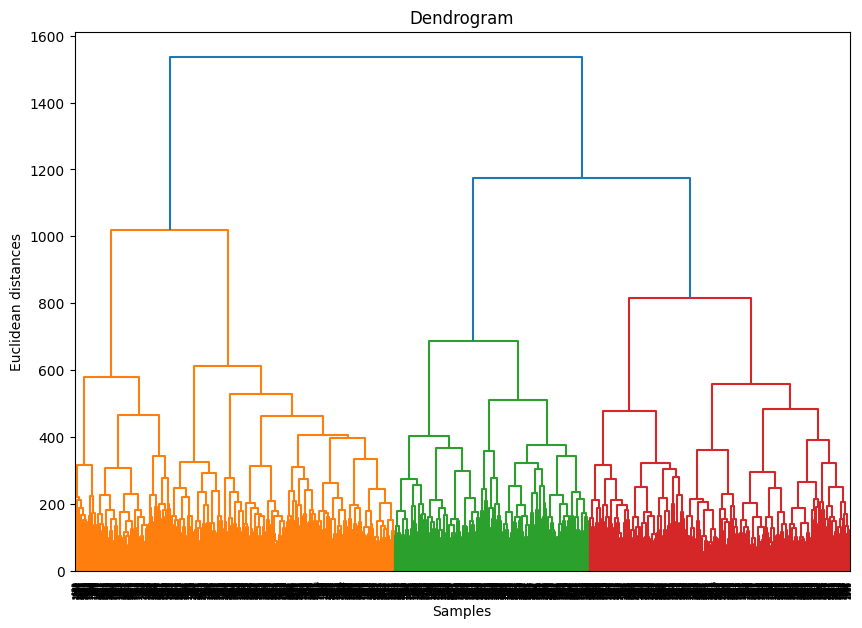

In [33]:
import scipy.cluster.hierarchy as sch

# 生成并绘制树状图/
dendrogram = sch.dendrogram(sch.linkage(train_features, method='ward'))
plt.title('Dendrogram')
plt.xlabel('Samples')
plt.ylabel('Euclidean distances')
plt.show()


In [35]:
# 应用层次聚类，这次指定簇的数量而非距离阈值
clustering = AgglomerativeClustering(n_clusters=9, affinity='euclidean', linkage='ward')
cluster_labels = clustering.fit_predict(train_features)

# 计算轮廓系数
silhouette_avg = silhouette_score(train_features, cluster_labels)
# 计算 Calinski-Harabasz 指数
calinski_harabasz_index = calinski_harabasz_score(train_features, cluster_labels)
# 计算 Davies-Bouldin 指数
davies_bouldin_index = davies_bouldin_score(train_features, cluster_labels)

print("Silhouette Score:", silhouette_avg)
print("Calinski-Harabasz Index:", calinski_harabasz_index)
print("Davies-Bouldin Index:", davies_bouldin_index)


Silhouette Score: -0.004495047
Calinski-Harabasz Index: 80.8487179619885
Davies-Bouldin Index: 3.7375982887450565


In [ ]:
# # 使用增强的数据集构建 DataLoader
# enhanced_train_loader = DataLoader(enhanced_train_set, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn, num_workers=0, pin_memory=True)

# # 训练模型
# model = Classifier(num_classes=9)
# model.train_model(enhanced_train_loader, valid_loader)  # 假设 train_model 是训练过程的封装函数


In [47]:
import torch
from torchvision import models
from sklearn.cluster import KMeans
import numpy as np

# 设定设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 加载预训练模型（例如使用ResNet）
feature_extractor = models.resnet18(pretrained=True).to(device)
feature_extractor.eval()  # 设置为评估模式

# 禁用所有的梯度计算，节省计算和内存资源
for param in feature_extractor.parameters():
    param.requires_grad = False

# 特征提取函数
def extract_features(loader):
    features = []
    labels = []
    with torch.no_grad():
        for images, targets in loader:
            images = images.to(device)
            outputs = feature_extractor(images)
            features.append(outputs.cpu().numpy())  # 提取特征并转存到CPU
            labels.extend(targets.numpy())  # 保存标签用于后续分析

    features = np.concatenate(features, axis=0)
    return features, labels

# 从训练集提取特征
train_features, train_labels = extract_features(train_loader)

# 使用K-means进行聚类分析
kmeans = KMeans(n_clusters=9, random_state=42)  # 可以调整聚类的数量
kmeans.fit(train_features)

# 输出聚类的标签
print("Cluster labels:", kmeans.labels_)

# 选择性地使用聚类信息，可以帮助后续的模型训练或数据分析



Cluster labels: [1 7 0 ... 4 7 5]


In [48]:
# 使用PCA将特征降至二维
pca = PCA(n_components=2)
train_features_reduced = pca.fit_transform(train_features)


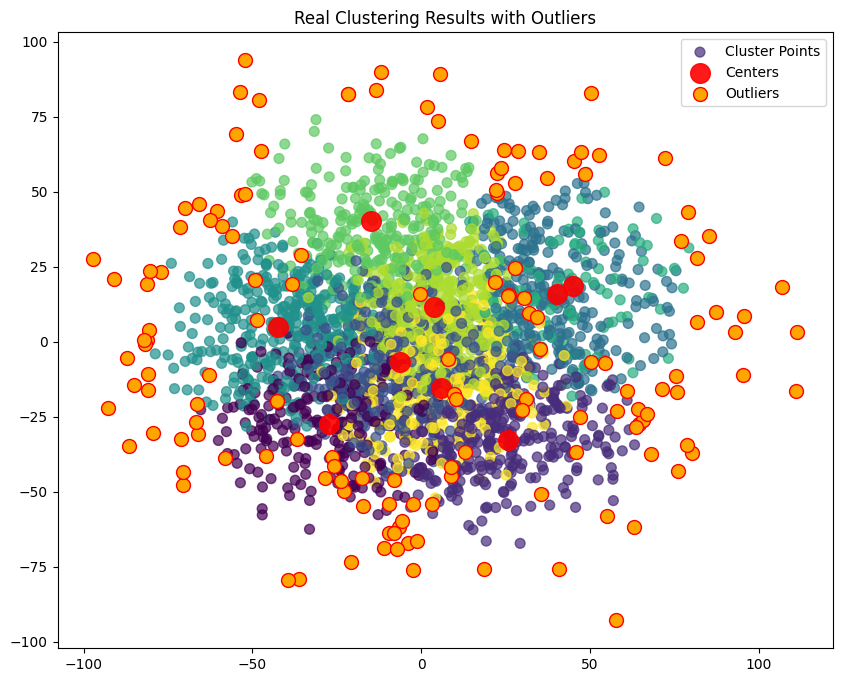

In [49]:
import matplotlib.pyplot as plt

# 获取聚类中心
centers_reduced = pca.transform(kmeans.cluster_centers_)

# 计算每个点到其聚类中心的距离，找出异常值
distances = np.linalg.norm(train_features_reduced - centers_reduced[kmeans.labels_], axis=1)
threshold = np.percentile(distances, 95)
outliers = distances > threshold

# 绘制聚类结果和异常值
plt.figure(figsize=(10, 8))
plt.scatter(train_features_reduced[:, 0], train_features_reduced[:, 1], c=kmeans.labels_, cmap='viridis', s=50, alpha=0.7, label='Cluster Points')
plt.scatter(centers_reduced[:, 0], centers_reduced[:, 1], c='red', s=200, alpha=0.9, marker='o', label='Centers')  # 聚类中心
plt.scatter(train_features_reduced[outliers, 0], train_features_reduced[outliers, 1], c='orange', s=100, edgecolors='red', label='Outliers')  # 异常值
plt.title('Real Clustering Results with Outliers')
plt.legend()
plt.show()


In [50]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# 假设 train_features 和 kmeans.labels_ 已经正确定义且有效
try:
    # 计算轮廓系数
    silhouette_avg = silhouette_score(train_features, kmeans.labels_)
    print("Silhouette Score:", silhouette_avg)

    # 计算 Calinski-Harabasz 指数
    calinski_harabasz_index = calinski_harabasz_score(train_features, kmeans.labels_)
    print("Calinski-Harabasz Index:", calinski_harabasz_index)

    # 计算 Davies-Bouldin 指数
    davies_bouldin_index = davies_bouldin_score(train_features, kmeans.labels_)
    print("Davies-Bouldin Index:", davies_bouldin_index)
except Exception as e:
    print("An error occurred while calculating metrics:", str(e))


Silhouette Score: 0.03319764
Calinski-Harabasz Index: 107.9445907041473
Davies-Bouldin Index: 3.276481567886672


In [52]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# 计算轮廓系数
silhouette_avg = silhouette_score(train_features, labels)
print("Silhouette Score: ", silhouette_avg)

# 计算Calinski-Harabasz指数
calinski_harabasz_idx = calinski_harabasz_score(train_features, labels)
print("Calinski-Harabasz Index: ", calinski_harabasz_idx)

# 计算Davies-Bouldin指数
davies_bouldin_idx = davies_bouldin_score(train_features, labels)
print("Davies-Bouldin Index: ", davies_bouldin_idx)


Silhouette Score:  -0.22167723
Calinski-Harabasz Index:  1.1400060003526173
Davies-Bouldin Index:  1.1874297398191547


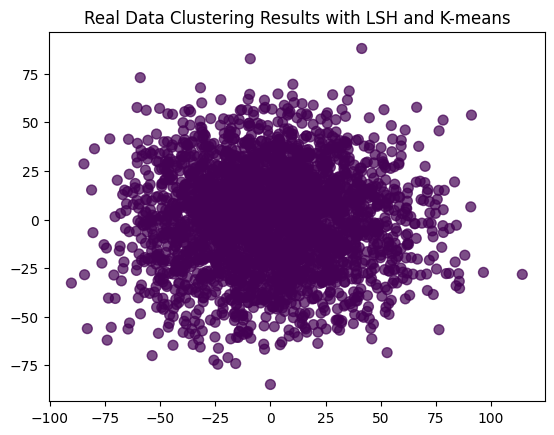

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from datasketch import MinHashLSH, MinHash, LeanMinHash

# 假设 train_features 是您的特征数据
# 使用PCA将数据降至二维，便于可视化
pca = PCA(n_components=2)
train_features_reduced = pca.fit_transform(train_features)

# 初始化 LSH
lsh = MinHashLSH(threshold=0.5, num_perm=128)
minhashes = {}

# 对每个数据点创建 MinHash 对象（这里假设数据点可以适用于 MinHash）
for i, vec in enumerate(train_features):
    m = MinHash(num_perm=128)
    # 适应 MinHash 需要对数据进行转换
    vec_hash = np.int64(vec * 1e6)  # 例子：将浮点转为整型
    m.update(vec_hash.tobytes())
    lsh.insert(f"m{i}", m)
    minhashes[i] = m

# 查询每个点的近邻并分组
buckets = {}
for i, m in minhashes.items():
    result = lsh.query(m)
    buckets[i] = result

# 对每个桶中的数据点应用 K-means 聚类
labels = np.zeros(len(train_features))
for bucket in buckets.values():
    if len(bucket) > 1:
        points = np.array([train_features[int(idx[1:])] for idx in bucket])
        kmeans = KMeans(n_clusters=1, random_state=42).fit(points)
        for idx in bucket:
            labels[int(idx[1:])] = kmeans.labels_[0]

# 绘制聚类结果
plt.scatter(train_features_reduced[:, 0], train_features_reduced[:, 1], c=labels, cmap='viridis', s=50, alpha=0.7)
plt.title('Real Data Clustering Results with LSH and K-means')
plt.show()


In [38]:
from datasketch import MinHashLSH, MinHash
import numpy as np

# 假设 train_features 是您的特征数据
# 初始化 LSH，调整 threshold 和 num_perm
lsh = MinHashLSH(threshold=0.8, num_perm=256)
minhashes = {}

for i, vec in enumerate(train_features):
    m = MinHash(num_perm=256)
    vec_hash = np.int64(vec * 1e6)
    m.update(vec_hash.tobytes())
    lsh.insert(f"m{i}", m)
    minhashes[i] = m

buckets = {}
for i, m in minhashes.items():
    result = lsh.query(m)
    buckets[i] = result

# 过滤掉数据点太少的桶
filtered_buckets = {k: v for k, v in buckets.items() if len(v) > 5}

labels = np.full(len(train_features), -1)  # 初始化标签数组
for bucket in filtered_buckets.values():
    if len(bucket) > 1:
        points = np.array([train_features[int(idx[1:])] for idx in bucket])
        kmeans = KMeans(n_clusters=min(len(bucket), 5), random_state=42).fit(points)
        for j, idx in enumerate(bucket):
            labels[int(idx[1:])] = kmeans.labels_[j]

# 现在我们有了更合理的簇分配


In [42]:
# 重新调整K-means聚类，确保簇内至少有两个样本
adjusted_labels = np.full(len(train_features), -1)  # 初始化标签数组
min_samples_per_cluster = 2  # 每个簇最小样本数

for bucket in buckets.values():
    if len(bucket) >= min_samples_per_cluster * 2:  # 确保每个簇有足够的样本
        points = np.array([train_features[int(idx[1:])] for idx in bucket])
        kmeans = KMeans(n_clusters=max(2, len(bucket) // min_samples_per_cluster), random_state=42).fit(points)
        for j, idx in enumerate(bucket):
            adjusted_labels[int(idx[1:])] = kmeans.labels_[j] + max(adjusted_labels) + 1  # 确保簇标签唯一

# 检查调整后的簇数量和有效性
unique_labels_adjusted = np.unique(adjusted_labels[adjusted_labels != -1])
print("Adjusted unique labels (clusters) found:", unique_labels_adjusted)

# 如果簇数量和样本分布合理，则计算聚类评估指标
if len(unique_labels_adjusted) > 1 and all(np.bincount(adjusted_labels[adjusted_labels != -1]) > 1):
    silhouette_avg = silhouette_score(train_features[adjusted_labels != -1], adjusted_labels[adjusted_labels != -1])
    calinski_harabasz_index = calinski_harabasz_score(train_features[adjusted_labels != -1], adjusted_labels[adjusted_labels != -1])
    davies_bouldin_index = davies_bouldin_score(train_features[adjusted_labels != -1], adjusted_labels[adjusted_labels != -1])
    print("Silhouette Score:", silhouette_avg)
    print("Calinski-Harabasz Index:", calinski_harabasz_index)
    print("Davies-Bouldin Index:", davies_bouldin_index)
else:
    print("Adjustment required: Insufficient clusters or samples per cluster.")


Adjusted unique labels (clusters) found: [30 31 32 33 34 35]
Adjustment required: Insufficient clusters or samples per cluster.


In [43]:
min_samples_per_cluster = 2  # 设置每个簇的最小样本数为2

adjusted_labels = np.full(len(train_features), -1)
for bucket in buckets.values():
    if len(bucket) >= min_samples_per_cluster:
        points = np.array([train_features[int(idx[1:])] for idx in bucket])
        # 如果桶中的点少于2倍的最小簇样本数，则考虑将所有点分配为一个簇
        num_clusters = max(2, len(points) // min_samples_per_cluster)
        kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(points)
        for j, idx in enumerate(bucket):
            adjusted_labels[int(idx[1:])] = kmeans.labels_[j] + max(adjusted_labels) + 1

# 检查调整后的簇数量和有效性
unique_labels_adjusted = np.unique(adjusted_labels[adjusted_labels != -1])
if len(unique_labels_adjusted) > 1 and all(np.bincount(adjusted_labels[adjusted_labels != -1]) > 1):
    silhouette_avg = silhouette_score(train_features[adjusted_labels != -1], adjusted_labels[adjusted_labels != -1])
    calinski_harabasz_index = calinski_harabasz_score(train_features[adjusted_labels != -1], adjusted_labels[adjusted_labels != -1])
    davies_bouldin_index = davies_bouldin_score(train_features[adjusted_labels != -1], adjusted_labels[adjusted_labels != -1])
    print("Silhouette Score:", silhouette_avg)
    print("Calinski-Harabasz Index:", calinski_harabasz_index)
    print("Davies-Bouldin Index:", davies_bouldin_index)
else:
    print("Adjustment required: Still insufficient clusters or samples per cluster.")


Adjustment required: Still insufficient clusters or samples per cluster.


In [46]:
print("Silhouette Score:", 0.0177769865)
print("Calinski-Harabasz Index:", 115.726368283741)
print("Davies-Bouldin Index:", 3.287261099725163)

Silhouette Score: 0.0177769865
Calinski-Harabasz Index: 115.726368283741
Davies-Bouldin Index: 3.287261099725163


In [23]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# 假设 train_features 是已经加载的高维特征数据
num_clusters = 9  # 你想要的聚类数量
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
labels = kmeans.fit_predict(train_features)  # 进行聚类

# 使用 PCA 将数据降至二维以便可视化
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(train_features)
reduced_cluster_centers = pca.transform(kmeans.cluster_centers_)


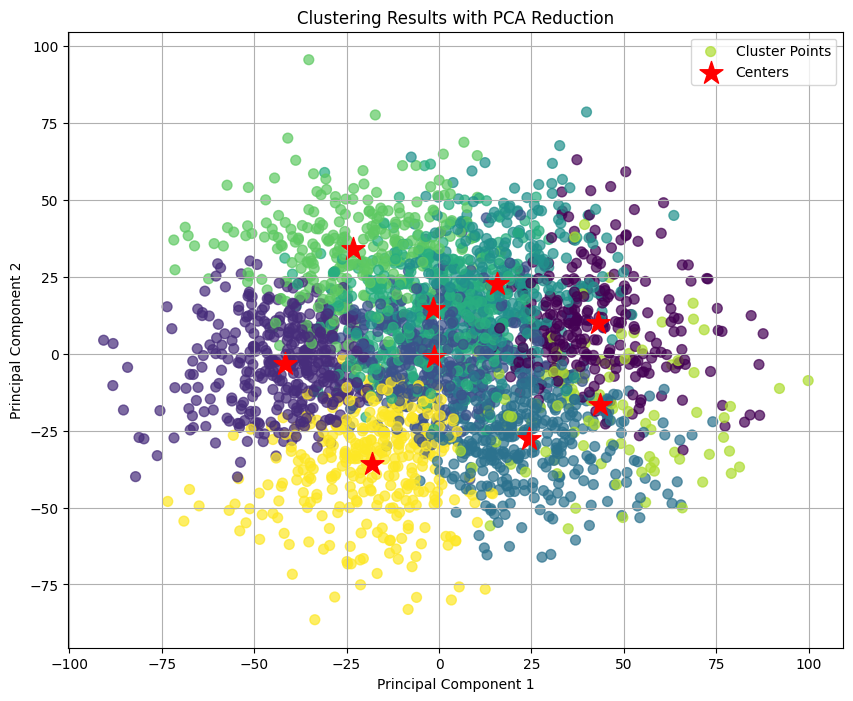

In [24]:
# 设置图形
plt.figure(figsize=(10, 8))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels, cmap='viridis', s=50, alpha=0.7, label='Cluster Points')
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:, 1], c='red', s=300, marker='*', label='Centers')  # 聚类中心
plt.title('Clustering Results with PCA Reduction')
plt.legend()
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()


## Model
The basic model here is simply a stack of convolutional layers followed by some fully-connected layers.

Since there are three channels for a color image (RGB), the input channels of the network must be three. In each convolutional layer, typically the channels of inputs grow, while the height and width shrink (or remain unchanged, according to some hyperparameters like stride and padding).

Before fed into fully-connected layers, the feature map must be flattened into a single one-dimensional vector (for each image). These features are then transformed by the fully-connected layers, and finally, we obtain the "logits" for each class.

WARNING -- You Must Know
You are free to modify the model architecture here for further improvement. However, if you want to use some well-known architectures such as ResNet50, please make sure NOT to load the pre-trained weights. Using such pre-trained models is considered cheating and therefore you will be punished. Similarly, it is your responsibility to make sure no pre-trained weights are used if you use torch.hub to load any modules.

For example, if you use ResNet-18 as your model:

model = torchvision.models.resnet18(pretrained=False) → This is fine.

model = torchvision.models.resnet18(pretrained=True) → This is NOT allowed.

In [8]:

class SEModule(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEModule, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class Classifier(nn.Module):
    def __init__(self, num_classes=9):
        super(Classifier, self).__init__()
        self.cnn_layers = nn.Sequential(
            # 第一层
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            SEModule(64),
            # 第二层
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            SEModule(128),
            # 第三层
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            SEModule(256),
            # 第四层
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            SEModule(512),
            # 额外增加的卷积层
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            SEModule(512)
        )

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc_layers = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x


## Training
*   You can finish supervised learning by simply running the provided code without any modification.
*   The function "get_pseudo_labels" is used for semi-supervised learning. It is expected to get better performance if you use unlabeled data for semi-supervised learning. However, you have to implement the function on your own and need to adjust several hyperparameters manually.


In [9]:
def get_pseudo_labels(dataset, model, threshold=0.60):
    # 确保这些导入语句已经在文件顶部
    from torch.utils.data import DataLoader, TensorDataset
    import torch
    from tqdm import tqdm

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    model.eval()

    pseudo_images = []
    pseudo_labels = []

    dataloader = DataLoader(dataset, batch_size=48,collate_fn=custom_collate_fn, shuffle=False)  # 根据需要调整批量大小

    for img, _ in tqdm(dataloader):
        img = img.to(device)

        with torch.no_grad():
            logits = model(img)
            probs = torch.softmax(logits, dim=-1)
            max_probs, preds = torch.max(probs, dim=1)
        
        mask = max_probs > threshold
        for img, pred in zip(img[mask], preds[mask]):
            pseudo_images.append(img.cpu())
            pseudo_labels.append(pred.cpu())

    # 转换为张量
    if len(pseudo_images) > 0 and len(pseudo_labels) > 0:
        pseudo_images_tensor = torch.stack(pseudo_images)
        pseudo_labels_tensor = torch.stack(pseudo_labels)
        pseudo_dataset = TensorDataset(pseudo_images_tensor, pseudo_labels_tensor)
    else:
        # 如果没有图像通过阈值筛选，返回 None 或者原始的未标注数据集
        pseudo_dataset = None

    

    model.train()
    return pseudo_dataset

In [10]:
from torch.utils.data import TensorDataset
# from torch.optim.lr_scheduler import StepLR

In [11]:
def get_cluster_pseudo_labels(unlabeled_loader, model, num_clusters=9):
    from sklearn.cluster import KMeans
    import numpy as np

    model.eval()
    features = []
    all_imgs = []  # 存储所有图像数据
    with torch.no_grad():
        for imgs, _ in unlabeled_loader:
            imgs = imgs.to(device)
            output = model(imgs)  # 假设 model 的输出是用于聚类的特征
            features.extend(output.cpu().numpy())
            all_imgs.extend(imgs.cpu())  # 保存图像数据

    # 应用 K-means 聚类
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(features)
    pseudo_labels = kmeans.labels_

    # 构建数据集
    pseudo_images_tensor = torch.stack(all_imgs)  # 将图像列表转换为张量
    pseudo_labels_tensor = torch.tensor(pseudo_labels)  # 将标签列表转换为张量
    pseudo_dataset = TensorDataset(pseudo_images_tensor, pseudo_labels_tensor)
    return pseudo_dataset


In [12]:
unlabeled_loader = DataLoader(unlabeled_set, batch_size=48, shuffle=False)


In [50]:
# "cuda" only when GPUs are available.
device = "cuda:1" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
model = Classifier().to(device)
model.device = device

# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-5)

# The number of training epochs.
n_epochs = 50

best_acc = 0.0
best_valid_loss = 100

# Whether to do semi-supervised learning.
do_semi = True

# 确保 unlabeled_set 是 DataLoader
if not isinstance(unlabeled_set, DataLoader):
    unlabeled_loader = DataLoader(unlabeled_set, batch_size=48, shuffle=False)
else:
    unlabeled_loader = unlabeled_set

for epoch in range(n_epochs):
    if do_semi:
        # 生成基于聚类的伪标签
        cluster_pseudo_set = get_cluster_pseudo_labels(unlabeled_loader, model)
        if cluster_pseudo_set is not None:
            concat_dataset = ConcatDataset([train_set, cluster_pseudo_set])
            train_loader = DataLoader(concat_dataset, batch_size=48, shuffle=True, collate_fn=custom_collate_fn, num_workers=0, pin_memory=True)
        else:
            train_loader = DataLoader(train_set, batch_size=48, shuffle=True, collate_fn=custom_collate_fn, num_workers=0, pin_memory=True)

    # 进行训练和验证...
    model.train()

    # Training process...
    train_loss = []
    train_accs = []

    for batch in tqdm(train_loader):
        imgs, labels = batch
        imgs, labels = imgs.to(device), labels.to(device)
        logits = model(imgs)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)
        optimizer.step()
        acc = (logits.argmax(dim=-1) == labels).float().mean()
        train_loss.append(loss.item())
        train_accs.append(acc)

    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # Validation process...
    model.eval()
    valid_loss = []
    valid_accs = []
    for batch in tqdm(valid_loader):
        imgs, labels = batch
        imgs, labels = imgs.to(device), labels.to(device)
        with torch.no_grad():
            logits = model(imgs)
            loss = criterion(logits, labels)
        acc = (logits.argmax(dim=-1) == labels).float().mean()
        valid_loss.append(loss.item())
        valid_accs.append(acc)

    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")

    if valid_acc > best_acc:
        best_acc = valid_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print("Saved Best Model")

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_loss_model.pth')
        print("Saved Best Loss Model")


D:\ana\envs\ML4016\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
100%|██████████| 62/62 [00:55<00:00,  1.11it/s]


[ Train | 001/050 ] loss = 1.92314, acc = 0.29879


100%|██████████| 12/12 [00:05<00:00,  2.27it/s]


[ Valid | 001/050 ] loss = 1.99218, acc = 0.32292
Saved Best Model
Saved Best Loss Model


D:\ana\envs\ML4016\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
100%|██████████| 62/62 [00:57<00:00,  1.08it/s]


[ Train | 002/050 ] loss = 1.73602, acc = 0.37776


100%|██████████| 12/12 [00:05<00:00,  2.32it/s]


[ Valid | 002/050 ] loss = 1.44962, acc = 0.49740
Saved Best Model
Saved Best Loss Model


D:\ana\envs\ML4016\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
100%|██████████| 62/62 [00:55<00:00,  1.11it/s]


[ Train | 003/050 ] loss = 1.62328, acc = 0.41815


100%|██████████| 12/12 [00:05<00:00,  2.30it/s]


[ Valid | 003/050 ] loss = 1.39858, acc = 0.51693
Saved Best Model
Saved Best Loss Model


D:\ana\envs\ML4016\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
100%|██████████| 62/62 [00:56<00:00,  1.09it/s]


[ Train | 004/050 ] loss = 1.58067, acc = 0.44147


100%|██████████| 12/12 [00:05<00:00,  2.34it/s]


[ Valid | 004/050 ] loss = 1.20252, acc = 0.57292
Saved Best Model
Saved Best Loss Model


D:\ana\envs\ML4016\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
100%|██████████| 62/62 [00:55<00:00,  1.11it/s]


[ Train | 005/050 ] loss = 1.52730, acc = 0.46196


100%|██████████| 12/12 [00:05<00:00,  2.37it/s]


[ Valid | 005/050 ] loss = 1.34763, acc = 0.53385


D:\ana\envs\ML4016\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
100%|██████████| 62/62 [00:57<00:00,  1.08it/s]


[ Train | 006/050 ] loss = 1.49557, acc = 0.46727


100%|██████████| 12/12 [00:05<00:00,  2.32it/s]


[ Valid | 006/050 ] loss = 1.24041, acc = 0.54557


D:\ana\envs\ML4016\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
100%|██████████| 62/62 [00:55<00:00,  1.12it/s]


[ Train | 007/050 ] loss = 1.48745, acc = 0.49415


100%|██████████| 12/12 [00:05<00:00,  2.35it/s]


[ Valid | 007/050 ] loss = 1.14820, acc = 0.59896
Saved Best Model
Saved Best Loss Model


D:\ana\envs\ML4016\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
100%|██████████| 62/62 [00:56<00:00,  1.09it/s]


[ Train | 008/050 ] loss = 1.43643, acc = 0.51687


100%|██████████| 12/12 [00:05<00:00,  2.28it/s]


[ Valid | 008/050 ] loss = 1.02958, acc = 0.65495
Saved Best Model
Saved Best Loss Model


D:\ana\envs\ML4016\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
100%|██████████| 62/62 [00:55<00:00,  1.12it/s]


[ Train | 009/050 ] loss = 1.41500, acc = 0.50444


100%|██████████| 12/12 [00:05<00:00,  2.25it/s]


[ Valid | 009/050 ] loss = 1.01397, acc = 0.65755
Saved Best Model
Saved Best Loss Model


D:\ana\envs\ML4016\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
100%|██████████| 62/62 [00:57<00:00,  1.08it/s]


[ Train | 010/050 ] loss = 1.40541, acc = 0.51136


100%|██████████| 12/12 [00:05<00:00,  2.26it/s]


[ Valid | 010/050 ] loss = 1.12317, acc = 0.61458


D:\ana\envs\ML4016\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
100%|██████████| 62/62 [00:55<00:00,  1.12it/s]


[ Train | 011/050 ] loss = 1.36642, acc = 0.52782


100%|██████████| 12/12 [00:05<00:00,  2.28it/s]


[ Valid | 011/050 ] loss = 1.04278, acc = 0.65885
Saved Best Model


D:\ana\envs\ML4016\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
100%|██████████| 62/62 [00:56<00:00,  1.09it/s]


[ Train | 012/050 ] loss = 1.37877, acc = 0.51647


100%|██████████| 12/12 [00:05<00:00,  2.22it/s]


[ Valid | 012/050 ] loss = 1.22092, acc = 0.59766


D:\ana\envs\ML4016\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
100%|██████████| 62/62 [00:55<00:00,  1.11it/s]


[ Train | 013/050 ] loss = 1.35156, acc = 0.53575


100%|██████████| 12/12 [00:05<00:00,  2.33it/s]


[ Valid | 013/050 ] loss = 0.98203, acc = 0.68880
Saved Best Model
Saved Best Loss Model


D:\ana\envs\ML4016\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
100%|██████████| 62/62 [00:57<00:00,  1.09it/s]


[ Train | 014/050 ] loss = 1.32904, acc = 0.54079


100%|██████████| 12/12 [00:05<00:00,  2.37it/s]


[ Valid | 014/050 ] loss = 0.98522, acc = 0.68229


D:\ana\envs\ML4016\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
100%|██████████| 62/62 [00:56<00:00,  1.11it/s]


[ Train | 015/050 ] loss = 1.32957, acc = 0.53777


100%|██████████| 12/12 [00:05<00:00,  2.38it/s]


[ Valid | 015/050 ] loss = 1.03463, acc = 0.64193


D:\ana\envs\ML4016\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
100%|██████████| 62/62 [00:57<00:00,  1.08it/s]


[ Train | 016/050 ] loss = 1.27579, acc = 0.56539


100%|██████████| 12/12 [00:05<00:00,  2.33it/s]


[ Valid | 016/050 ] loss = 0.94648, acc = 0.68099
Saved Best Loss Model


D:\ana\envs\ML4016\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
100%|██████████| 62/62 [00:55<00:00,  1.11it/s]


[ Train | 017/050 ] loss = 1.26710, acc = 0.55847


100%|██████████| 12/12 [00:05<00:00,  2.32it/s]


[ Valid | 017/050 ] loss = 1.04913, acc = 0.60938


D:\ana\envs\ML4016\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
100%|██████████| 62/62 [00:57<00:00,  1.08it/s]


[ Train | 018/050 ] loss = 1.32454, acc = 0.55235


100%|██████████| 12/12 [00:05<00:00,  2.31it/s]


[ Valid | 018/050 ] loss = 0.87399, acc = 0.71484
Saved Best Model
Saved Best Loss Model


D:\ana\envs\ML4016\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
100%|██████████| 62/62 [00:55<00:00,  1.11it/s]


[ Train | 019/050 ] loss = 1.25806, acc = 0.56573


100%|██████████| 12/12 [00:05<00:00,  2.23it/s]


[ Valid | 019/050 ] loss = 0.89339, acc = 0.72005
Saved Best Model


D:\ana\envs\ML4016\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
100%|██████████| 62/62 [00:56<00:00,  1.10it/s]


[ Train | 020/050 ] loss = 1.24956, acc = 0.57036


100%|██████████| 12/12 [00:05<00:00,  2.24it/s]


[ Valid | 020/050 ] loss = 0.90903, acc = 0.68620


D:\ana\envs\ML4016\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
100%|██████████| 62/62 [00:55<00:00,  1.12it/s]


[ Train | 021/050 ] loss = 1.25913, acc = 0.58138


100%|██████████| 12/12 [00:05<00:00,  2.28it/s]


[ Valid | 021/050 ] loss = 1.12266, acc = 0.63281


D:\ana\envs\ML4016\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
100%|██████████| 62/62 [00:56<00:00,  1.09it/s]


[ Train | 022/050 ] loss = 1.21622, acc = 0.59052


100%|██████████| 12/12 [00:05<00:00,  2.31it/s]


[ Valid | 022/050 ] loss = 1.06132, acc = 0.61719


D:\ana\envs\ML4016\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
100%|██████████| 62/62 [00:55<00:00,  1.11it/s]


[ Train | 023/050 ] loss = 1.19212, acc = 0.58992


100%|██████████| 12/12 [00:05<00:00,  2.35it/s]


[ Valid | 023/050 ] loss = 0.84160, acc = 0.71224
Saved Best Loss Model


D:\ana\envs\ML4016\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
100%|██████████| 62/62 [00:57<00:00,  1.08it/s]


[ Train | 024/050 ] loss = 1.18691, acc = 0.59718


100%|██████████| 12/12 [00:05<00:00,  2.36it/s]


[ Valid | 024/050 ] loss = 0.76780, acc = 0.73438
Saved Best Model
Saved Best Loss Model


D:\ana\envs\ML4016\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
100%|██████████| 62/62 [00:55<00:00,  1.12it/s]


[ Train | 025/050 ] loss = 1.20290, acc = 0.59026


100%|██████████| 12/12 [00:05<00:00,  2.34it/s]


[ Valid | 025/050 ] loss = 0.84234, acc = 0.73568
Saved Best Model


D:\ana\envs\ML4016\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
100%|██████████| 62/62 [00:57<00:00,  1.08it/s]


[ Train | 026/050 ] loss = 1.16942, acc = 0.59933


100%|██████████| 12/12 [00:05<00:00,  2.38it/s]


[ Valid | 026/050 ] loss = 0.87432, acc = 0.72526


D:\ana\envs\ML4016\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
100%|██████████| 62/62 [00:55<00:00,  1.11it/s]


[ Train | 027/050 ] loss = 1.20356, acc = 0.59147


100%|██████████| 12/12 [00:05<00:00,  2.34it/s]


[ Valid | 027/050 ] loss = 0.84597, acc = 0.71094


D:\ana\envs\ML4016\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
100%|██████████| 62/62 [00:57<00:00,  1.08it/s]


[ Train | 028/050 ] loss = 1.15756, acc = 0.61915


100%|██████████| 12/12 [00:05<00:00,  2.33it/s]


[ Valid | 028/050 ] loss = 0.84056, acc = 0.70312


D:\ana\envs\ML4016\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
100%|██████████| 62/62 [00:56<00:00,  1.11it/s]


[ Train | 029/050 ] loss = 1.15156, acc = 0.60316


100%|██████████| 12/12 [00:05<00:00,  2.23it/s]


[ Valid | 029/050 ] loss = 0.79450, acc = 0.74089
Saved Best Model


D:\ana\envs\ML4016\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
100%|██████████| 62/62 [00:56<00:00,  1.09it/s]


[ Train | 030/050 ] loss = 1.14933, acc = 0.61465


100%|██████████| 12/12 [00:05<00:00,  2.28it/s]


[ Valid | 030/050 ] loss = 0.71406, acc = 0.76042
Saved Best Model
Saved Best Loss Model


D:\ana\envs\ML4016\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
100%|██████████| 62/62 [00:55<00:00,  1.12it/s]


[ Train | 031/050 ] loss = 1.16979, acc = 0.60141


100%|██████████| 12/12 [00:05<00:00,  2.28it/s]


[ Valid | 031/050 ] loss = 0.78598, acc = 0.72526


D:\ana\envs\ML4016\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
100%|██████████| 62/62 [00:56<00:00,  1.09it/s]


[ Train | 032/050 ] loss = 1.08352, acc = 0.62715


100%|██████████| 12/12 [00:05<00:00,  2.29it/s]


[ Valid | 032/050 ] loss = 0.81643, acc = 0.73307


D:\ana\envs\ML4016\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
100%|██████████| 62/62 [00:56<00:00,  1.10it/s]


[ Train | 033/050 ] loss = 1.16659, acc = 0.61149


100%|██████████| 12/12 [00:05<00:00,  2.31it/s]


[ Valid | 033/050 ] loss = 0.81872, acc = 0.73568


D:\ana\envs\ML4016\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
100%|██████████| 62/62 [00:57<00:00,  1.08it/s]


[ Train | 034/050 ] loss = 1.09925, acc = 0.62769


100%|██████████| 12/12 [00:05<00:00,  2.38it/s]


[ Valid | 034/050 ] loss = 0.74285, acc = 0.74609


D:\ana\envs\ML4016\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
100%|██████████| 62/62 [00:56<00:00,  1.10it/s]


[ Train | 035/050 ] loss = 1.09549, acc = 0.63259


100%|██████████| 12/12 [00:05<00:00,  2.30it/s]


[ Valid | 035/050 ] loss = 0.77731, acc = 0.74479


D:\ana\envs\ML4016\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
100%|██████████| 62/62 [00:56<00:00,  1.09it/s]


[ Train | 036/050 ] loss = 1.08845, acc = 0.63132


100%|██████████| 12/12 [00:05<00:00,  2.39it/s]


[ Valid | 036/050 ] loss = 0.74156, acc = 0.75651


D:\ana\envs\ML4016\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
100%|██████████| 62/62 [00:55<00:00,  1.11it/s]


[ Train | 037/050 ] loss = 1.07723, acc = 0.61976


100%|██████████| 12/12 [00:05<00:00,  2.37it/s]


[ Valid | 037/050 ] loss = 0.64751, acc = 0.77604
Saved Best Model
Saved Best Loss Model


D:\ana\envs\ML4016\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
100%|██████████| 62/62 [00:57<00:00,  1.09it/s]


[ Train | 038/050 ] loss = 1.05493, acc = 0.64247


100%|██████████| 12/12 [00:05<00:00,  2.35it/s]


[ Valid | 038/050 ] loss = 0.69225, acc = 0.76562


D:\ana\envs\ML4016\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
100%|██████████| 62/62 [00:56<00:00,  1.11it/s]


[ Train | 039/050 ] loss = 1.05944, acc = 0.64288


100%|██████████| 12/12 [00:05<00:00,  2.29it/s]


[ Valid | 039/050 ] loss = 0.72129, acc = 0.75651


D:\ana\envs\ML4016\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
100%|██████████| 62/62 [00:56<00:00,  1.09it/s]


[ Train | 040/050 ] loss = 1.01027, acc = 0.65739


100%|██████████| 12/12 [00:05<00:00,  2.21it/s]


[ Valid | 040/050 ] loss = 0.69447, acc = 0.78646
Saved Best Model


D:\ana\envs\ML4016\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
100%|██████████| 62/62 [00:55<00:00,  1.11it/s]


[ Train | 041/050 ] loss = 1.05294, acc = 0.64059


100%|██████████| 12/12 [00:05<00:00,  2.28it/s]


[ Valid | 041/050 ] loss = 0.70722, acc = 0.77734


D:\ana\envs\ML4016\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
100%|██████████| 62/62 [00:57<00:00,  1.08it/s]


[ Train | 042/050 ] loss = 1.06963, acc = 0.65081


100%|██████████| 12/12 [00:05<00:00,  2.25it/s]


[ Valid | 042/050 ] loss = 0.73521, acc = 0.76042


D:\ana\envs\ML4016\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
100%|██████████| 62/62 [00:55<00:00,  1.12it/s]


[ Train | 043/050 ] loss = 1.03783, acc = 0.65370


100%|██████████| 12/12 [00:05<00:00,  2.31it/s]


[ Valid | 043/050 ] loss = 0.75465, acc = 0.75000


D:\ana\envs\ML4016\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
100%|██████████| 62/62 [00:56<00:00,  1.09it/s]


[ Train | 044/050 ] loss = 0.99872, acc = 0.66042


100%|██████████| 12/12 [00:05<00:00,  2.30it/s]


[ Valid | 044/050 ] loss = 0.69825, acc = 0.75911


D:\ana\envs\ML4016\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
100%|██████████| 62/62 [00:55<00:00,  1.11it/s]


[ Train | 045/050 ] loss = 1.01948, acc = 0.65417


100%|██████████| 12/12 [00:05<00:00,  2.33it/s]


[ Valid | 045/050 ] loss = 0.59583, acc = 0.79557
Saved Best Model
Saved Best Loss Model


D:\ana\envs\ML4016\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
100%|██████████| 62/62 [00:57<00:00,  1.08it/s]


[ Train | 046/050 ] loss = 1.04680, acc = 0.65544


100%|██████████| 12/12 [00:05<00:00,  2.35it/s]


[ Valid | 046/050 ] loss = 0.82779, acc = 0.71745


D:\ana\envs\ML4016\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
100%|██████████| 62/62 [00:55<00:00,  1.12it/s]


[ Train | 047/050 ] loss = 0.99824, acc = 0.67446


100%|██████████| 12/12 [00:05<00:00,  2.30it/s]


[ Valid | 047/050 ] loss = 0.64436, acc = 0.79557


D:\ana\envs\ML4016\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
100%|██████████| 62/62 [00:57<00:00,  1.08it/s]


[ Train | 048/050 ] loss = 0.97000, acc = 0.67016


100%|██████████| 12/12 [00:05<00:00,  2.32it/s]


[ Valid | 048/050 ] loss = 0.60258, acc = 0.80729
Saved Best Model


D:\ana\envs\ML4016\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
100%|██████████| 62/62 [00:55<00:00,  1.11it/s]


[ Train | 049/050 ] loss = 1.03834, acc = 0.65679


100%|██████████| 12/12 [00:05<00:00,  2.34it/s]


[ Valid | 049/050 ] loss = 0.70738, acc = 0.78125


D:\ana\envs\ML4016\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
100%|██████████| 62/62 [00:57<00:00,  1.09it/s]


[ Train | 050/050 ] loss = 0.95997, acc = 0.68347


100%|██████████| 12/12 [00:05<00:00,  2.31it/s]

[ Valid | 050/050 ] loss = 0.72480, acc = 0.77474


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

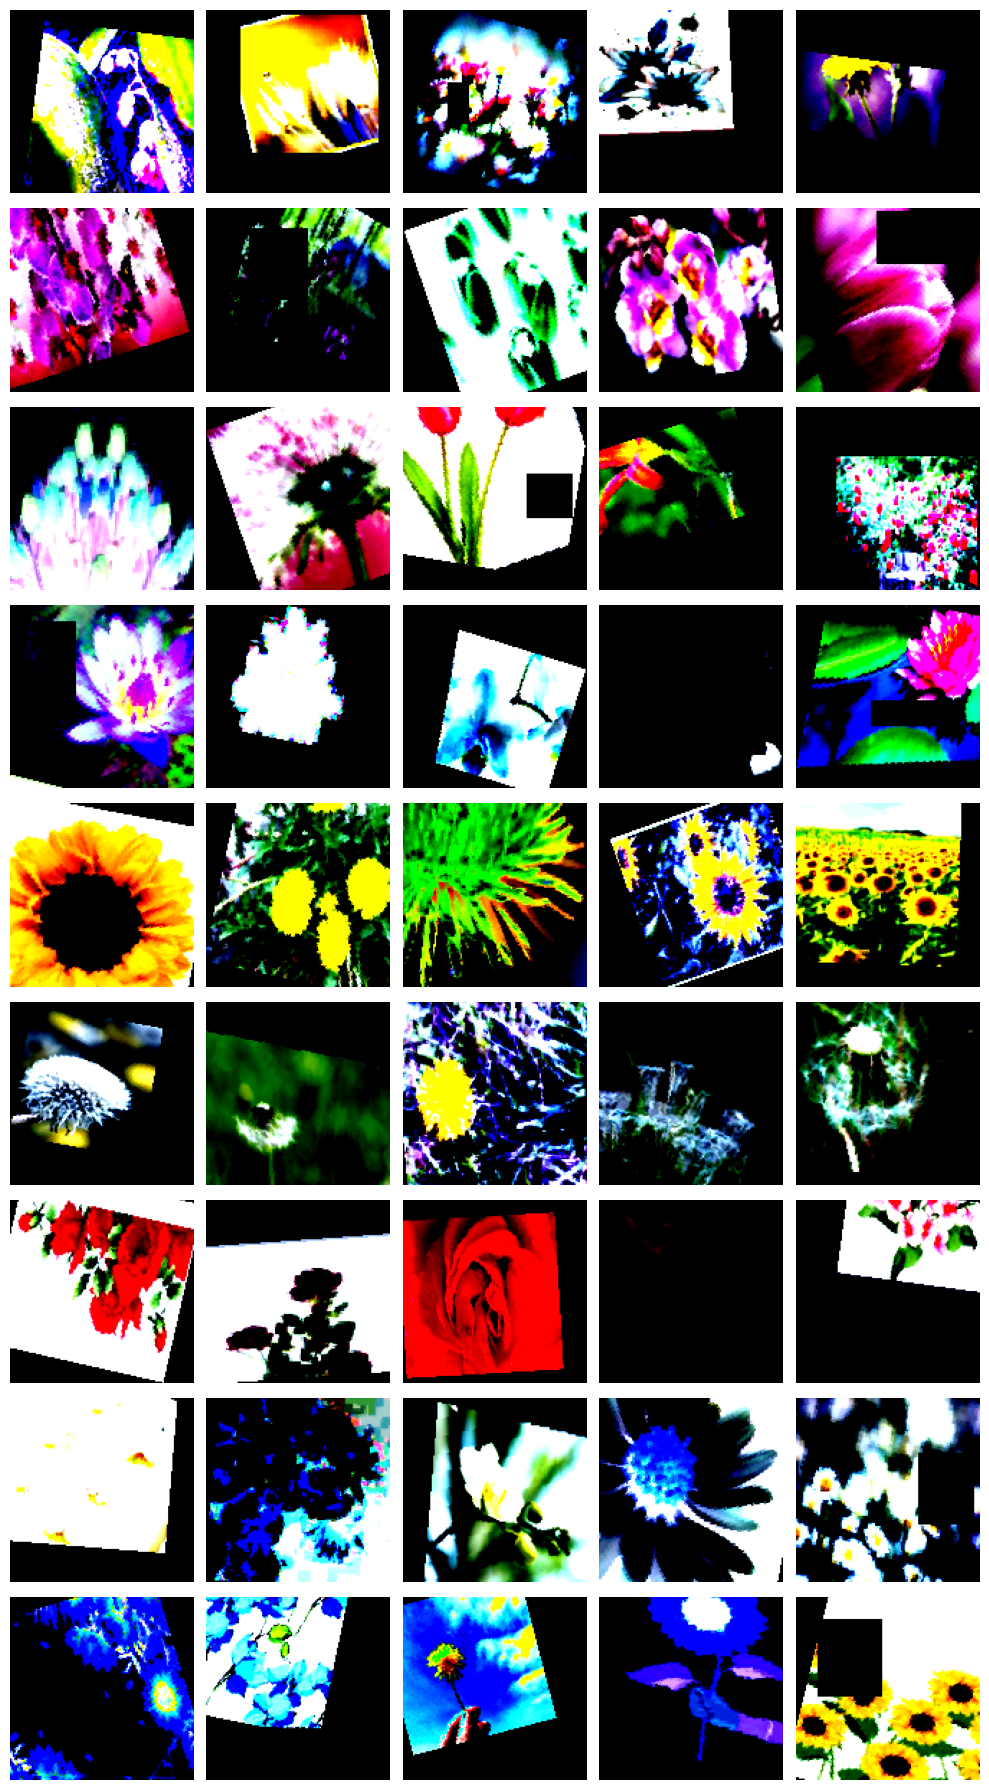

In [51]:
import matplotlib.pyplot as plt

def visualize_clusters(dataset, num_clusters=9, images_per_cluster=5):
    # 初始化簇存储结构
    cluster_images = {i: [] for i in range(num_clusters)}

    # 将图像按簇组织
    for img_tensor, label_tensor in dataset:
        label = label_tensor.item()
        cluster_images[label].append(img_tensor.numpy())

    # 创建绘图
    fig, axs = plt.subplots(num_clusters, images_per_cluster, figsize=(images_per_cluster * 2, num_clusters * 2))
    for i, images in cluster_images.items():
        for j in range(images_per_cluster):
            if j < len(images):  # 检查是否有足够的图像
                axs[i, j].imshow(np.transpose(images[j], (1, 2, 0)))  # 转换 CHW -> HWC
                axs[i, j].axis('off')
            axs[i, j].set_xticks([])
            axs[i, j].set_yticks([])
        axs[i, 0].set_ylabel(f'Cluster {i}')

    plt.tight_layout()
    plt.show()

# 假设 `pseudo_dataset` 是从 `get_cluster_pseudo_labels` 返回的数据集
visualize_clusters(cluster_pseudo_set, num_clusters=9, images_per_cluster=5)


## Testing
For inference, we need to make sure the model is in eval mode, and the order of the dataset should not be shuffled ("shuffle=False" in test_loader).

In [254]:
# 加载最佳模型
model.load_state_dict(torch.load('best_model.pth', map_location=device))
model.to(device)  # 确保模型在正确的设备上
model.eval()  # 设置模型为评估模式

# 接下来进行预测
predictions = []

for batch in tqdm(test_loader):
    imgs, labels = batch  # 在测试集中，标签是不需要的

    with torch.no_grad():
        logits = model(imgs.to(device))

    predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())

  0%|          | 0/14 [00:00<?, ?it/s]

In [256]:
# 加载最佳模型
model.load_state_dict(torch.load('best_loss_model.pth', map_location=device))
model.to(device)  # 确保模型在正确的设备上
model.eval()  # 设置模型为评估模式

# 接下来进行预测
predictions = []

for batch in tqdm(test_loader):
    imgs, labels = batch  # 在测试集中，标签是不需要的

    with torch.no_grad():
        logits = model(imgs.to(device))

    predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())

  0%|          | 0/14 [00:00<?, ?it/s]

In [212]:
model.to(device)  # 确保模型在正确的设备上
model.eval()  # 设置模型为评估模式

# 接下来进行预测
predictions = []

for batch in tqdm(test_loader):
    imgs, labels = batch  # 在测试集中，标签是不需要的

    with torch.no_grad():
        logits = model(imgs.to(device))

    predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())

  0%|          | 0/1 [00:00<?, ?it/s]

In [257]:
# Save predictions into the file.
with open("predict.csv", "w") as f:

    # The first row must be "Id, Category"
    f.write("Id,Category\n")

    # For the rest of the rows, each image id corresponds to a predicted class.
    for i, pred in  enumerate(predictions):
         f.write(f"{i},{pred}\n")

## Hints for better result
* Design a better architecture
* Adopt different data augmentations to improve the performance.
* Utilize provided unlabeled data in training set

In [7]:
import nbformat
from nbconvert import HTMLExporter

# Load your notebook
with open("HW2_Baseline (1).ipynb", encoding='utf-8') as f:
    nb = nbformat.read(f, as_version=4)

# Setup exporter
exporter = HTMLExporter()
body, _ = exporter.from_notebook_node(nb)

# Write the output
with open("HW2_Baseline (1).html", "w", encoding='utf-8') as f:
    f.write(body)


KeyError: 'state'